
# 프로젝트: 카메라 앱에 당황한 표정 효과를 적용해보기

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/gc-8-lecture-emoji.jpg)
<br></br>

그림처럼 놀라서 눈이 튀어나오는 듯 한 효과를 내봅시다. 우선 눈을 찾고, 눈에 효과를 적용해 보세요. 어려워 보여도 차근차근 한다면 충분히 간단한 프로토타입을 구현하실 수 있습니다.

## 1. 이론 시간에 다룬 모델을 참고하여 딥러닝 모델을 설계해 봅시다.

7 ~ 9번 스텝에서 키포인트 검출을 위한 딥러닝 모델을 만들어본 바 있습니다. 이를 활용해서 눈 이미지에서 적합한 키포인트를 찾는 딥러닝 모델을 구현해 봅시다. 이 모델의 학습을 위해서는 오늘 다룬 것처럼 데이터를 모아 데이터셋을 구축하는 과정이 함께 진행되어야 할 것입니다.

## 2. 눈동자 효과를 추가해 봅시다.

추출된 눈 위치에 위의 당황한 표정의 눈 이미지를 합성해 봅시다. 이렇게 합성된 이미지를 제출하는 것까지가 오늘 프로젝트 과제의 목표입니다.
***

## 1. 이론 시간에 다룬 모델을 참고하여 딥러닝 모델을 설계해 봅시다.

In [18]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

In [19]:
#  fine tuning

import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

24046 24078
Found 24032 images belonging to 1 classes.
Found 24064 images belonging to 1 classes.


In [20]:
# 제너레이터 생성

def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [21]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.      0.      1.      1.      0.3375  0.26875]
(80, 120, 3) [0.         0.         1.         1.         0.43333334 0.54805326]


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.


In [22]:
# 모델 구성

''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [24]:
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

In [25]:
# 모델 학습

steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

24032 32 751
Epoch 1/10


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.


751/751 [==============================] - 165s 220ms/step - loss: 0.0210 - mae: 0.0716
Epoch 2/10
751/751 [==============================] - 173s 230ms/step - loss: 0.0141 - mae: 0.0559
Epoch 3/10
751/751 [==============================] - 166s 222ms/step - loss: 0.0136 - mae: 0.0544
Epoch 4/10
751/751 [==============================] - 164s 219ms/step - loss: 0.0132 - mae: 0.0534
Epoch 5/10
751/751 [==============================] - 167s 223ms/step - loss: 0.0130 - mae: 0.0529
Epoch 6/10
751/751 [==============================] - 166s 221ms/step - loss: 0.0129 - mae: 0.0523
Epoch 7/10
751/751 [==============================] - 164s 219ms/step - loss: 0.0128 - mae: 0.0522
Epoch 8/10
751/751 [==============================] - 171s 228ms/step - loss: 0.0128 - mae: 0.0520
Epoch 9/10
751/751 [==============================] - 153s 204ms/step - loss: 0.0127 - mae: 0.0518
Epoch 10/10
751/751 [==============================] - 161s 215ms/step - loss: 0.0127 - mae: 0.0518


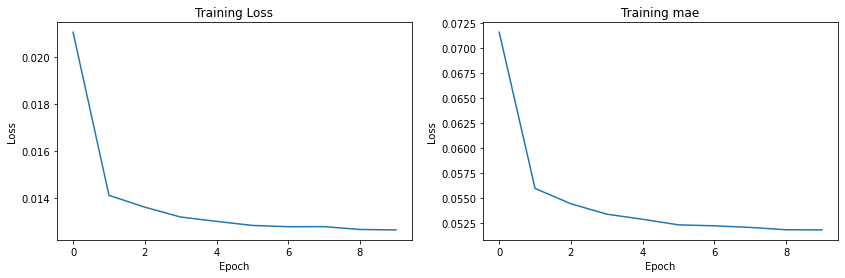

In [26]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.title('Training mae')
plt.plot(history.history['mae'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [27]:
# 모델 평가

IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2674 images belonging to 1 classes.
Found 2674 images belonging to 1 classes.


In [28]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.


0.013181611895561218 0.052785493433475494


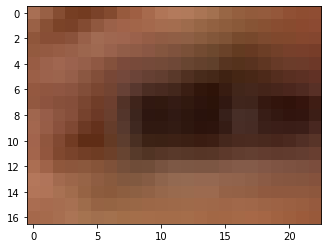

In [30]:
# img test

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_009820_r.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [31]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[1.0078311e-01 5.7718754e-02]
  [1.1991736e+02 7.9972862e+01]
  [4.9347874e+01 2.6979202e+01]]]


[0. 0.]
[120.  80.]
[49. 27.]


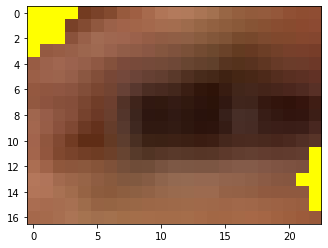

In [32]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 눈동자 효과를 추가해 봅시다.